In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

num_qubits = 7
dataset_filename = "dataset/dataset_tesi/NN1_Dataset(<=10Cx)_balanced1.csv"
df = pd.read_csv(dataset_filename)

links = [set([0,1]), set([1,2]), set([1,3]), set([3,5]), set([4,5]), set([5,6])]
def generate_columns(header, links, in_links=False):
    if in_links:
        return [header+str(i)+str(j) for i in range(num_qubits) for j in range(num_qubits) if set([i,j]) in links]
    else:
        return [header+str(i)+str(j) for i in range(num_qubits) for j in range(num_qubits) if set([i,j]) not in links and i!=j]

useless_columns = ['Unnamed: 0', 'last_update_date', 'N_qubtis', 'N_measure', 'N_cx', 'backend_name']
useless_columns += generate_columns("cx_", links)
useless_columns += generate_columns("edge_length_", links)
useless_columns += generate_columns("edge_error_", links)
useless_columns += ["measure_"+str(i) for i in range(num_qubits)]
# Note that cx/edge_error/edge_length_xy is not neccessarily the same as cx/edge_length/edge_error_yx
df.drop(columns=useless_columns, inplace=True)
df.drop_duplicates(inplace=True)

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train, test = train_test_split(df, test_size=0.2)
df_train_x, df_train_y= train.iloc[:, :-num_qubits], train.iloc[:, -num_qubits:]
df_test_x, df_test_y= test.iloc[:, :-num_qubits], test.iloc[:, -num_qubits:]

train_x = scaler.fit_transform(df_train_x)
test_x = scaler.fit_transform(df_test_x)


# for every row in y, convert to 1 hot-encoding and flatten
train_y = []
for _, row in df_train_y.iterrows():
    train_y.append(pd.get_dummies(row).values.flatten())
train_y = np.array(train_y)

test_y = []
for _, row in df_test_y.iterrows():
    test_y.append(pd.get_dummies(row).values.flatten())
test_y = np.array(test_y)

(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((7026, 57), (7026, 49), (1757, 57), (1757, 49))

# Simple MLP

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, hidden_channels)
        self.lin4 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        x = x.relu()
        x = self.lin4(x)
        return x

/home/jacky/anaconda3/envs/eece571f/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = MLP(57, 49, hidden_channels=128)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=5e-4)  # Define optimizer.

torch_train_x = torch.tensor(train_x, dtype=torch.float)
torch_train_y = torch.tensor(train_y, dtype=torch.float)
torch_test_x = torch.tensor(test_x, dtype=torch.float)
torch_test_y = torch.tensor(test_y, dtype=torch.float)

In [5]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(torch_train_x)  # Perform a single forward pass.
      loss = criterion(out, torch_train_y)  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(x, y):
      model.eval()
      pred = model(x)

      test_correct = 0
      for i, j in zip(pred, y):
          pred_i = np.argmax(i.detach().numpy().reshape(7,7), axis=1)
          label_j = np.argmax(j.detach().numpy().reshape(7,7), axis=1)
          test_correct += np.array_equal(pred_i, label_j)
      test_acc = int(test_correct) / int(y.shape[0])  # Derive ratio of correct predictions.
      return test_acc


In [6]:
for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 27.0795
Epoch: 002, Loss: 21.8784
Epoch: 003, Loss: 21.3658
Epoch: 004, Loss: 20.5554
Epoch: 005, Loss: 19.8338
Epoch: 006, Loss: 19.8830
Epoch: 007, Loss: 19.3283
Epoch: 008, Loss: 19.0172
Epoch: 009, Loss: 18.3522
Epoch: 010, Loss: 18.2405
Epoch: 011, Loss: 17.8325
Epoch: 012, Loss: 17.4914
Epoch: 013, Loss: 17.1906
Epoch: 014, Loss: 17.1535
Epoch: 015, Loss: 17.0007
Epoch: 016, Loss: 16.9130
Epoch: 017, Loss: 17.0232
Epoch: 018, Loss: 16.9232
Epoch: 019, Loss: 16.8283
Epoch: 020, Loss: 16.7672
Epoch: 021, Loss: 16.7065
Epoch: 022, Loss: 16.6304
Epoch: 023, Loss: 16.5409
Epoch: 024, Loss: 16.4578
Epoch: 025, Loss: 16.3857
Epoch: 026, Loss: 16.3437
Epoch: 027, Loss: 16.2987
Epoch: 028, Loss: 16.2615
Epoch: 029, Loss: 16.2335
Epoch: 030, Loss: 16.1881
Epoch: 031, Loss: 16.1539
Epoch: 032, Loss: 16.1089
Epoch: 033, Loss: 16.0738
Epoch: 034, Loss: 16.0460
Epoch: 035, Loss: 16.0170
Epoch: 036, Loss: 15.9896
Epoch: 037, Loss: 15.9751
Epoch: 038, Loss: 15.9979
Epoch: 039, 

In [8]:
training_acc = test(torch_train_x, torch_train_y)
print(f'Training Accuracy: {training_acc:.4f}')

testing_acc = test(torch_test_x, torch_test_y)
print(f'Training Accuracy: {testing_acc:.4f}')

Training Accuracy: 0.8898
Training Accuracy: 0.8577


# Simple GNN

In [9]:
################################################################################
# Here's how you would parse the data for GNNs if edge features can be added
################################################################################

# node_prefix = ["T1", "T2", "readout_error"]
# node_features_x = []
# for k in range(df_train_x.shape[0]):
#     node_features_j = []
#     for j in range(num_qubits):
#         row_features = df_train_x.iloc[k][[i + "_" + str(j) for i in node_prefix]].values.flatten()
#         node_features_j.append(row_features)
#     node_features_j = scaler.fit_transform(node_features_j)
#     node_features_x.append(node_features_j)
# node_features_x = np.array(node_features_x)

# edge_prefix = ["cx_", "edge_length_", "edge_error_"]
# edge_index = [[],[]]
# edge_features_x = []
# for k in range(df_train_x.shape[0]):
#     edge_features_j = []
#     for i in range(num_qubits):
#         for j in range(num_qubits):
#             if set([i,j]) in links:
#                 row_features = df_train_x.iloc[k][[prefix + str(i) + str(j) for prefix in edge_prefix]].values.flatten()
#                 edge_features_j.append(row_features)
#                 if k == 0: # only need to do this once
#                     edge_index[0].append(i)
#                     edge_index[1].append(j)
#     edge_features_j = scaler.fit_transform(edge_features_j)
#     edge_features_x.append(edge_features_j)
# edge_features_x = np.array(edge_features_x)
# edge_index = np.array(edge_index)

# node_labels = df_train_y.to_numpy()
# print(node_features_x.shape, edge_index.shape, edge_features_x.shape, node_labels.shape)

In [18]:
# Since GCN doesn't support edge features, we can just concatenate them to the node features
def get_datasets(df_x, df_y):
    node_prefix = ["T1", "T2", "readout_error"]
    edge_prefix = ["cx", "edge_length", "edge_error"]
    node_features_x = []
    edge_index = [[],[]]
    for k in range(df_x.shape[0]):
        node_features_i = []
        for i in range(num_qubits):
            node_features_i.append(list(df_train_x.iloc[k][[l + "_" + str(i) for l in node_prefix]].values.flatten()))
            for j in range(num_qubits):
                if set([i,j]) in links:
                    node_features_i[i].extend(df_train_x.iloc[k][[l + "_" + str(i)+str(j) for l in edge_prefix]].values.flatten())
                    if(k == 0): # only do this once
                        edge_index[0].append(i)
                        edge_index[1].append(j)
            if(len(node_features_i[i]) < 12): # pad features to 12 with standard normal
                node_features_i[i].extend(np.random.randn(12-len(node_features_i[i])))
        node_features_i = scaler.fit_transform(node_features_i)
        node_features_x.append(node_features_i)
    node_features_x = np.array(node_features_x)
    edge_index = np.array(edge_index)

    node_labels = []
    for _, row in df_y.iterrows():
        node_labels.append(pd.get_dummies(row).values.flatten())
    node_labels= np.array(node_labels)

    return node_features_x, edge_index, node_labels

train_gnn_x, edge_index, train_gnn_y = get_datasets(df_train_x, df_train_y)
test_gnn_x, edge_index, test_gnn_y = get_datasets(df_test_x, df_test_y)
print(train_gnn_x.shape, edge_index.shape, train_gnn_y.shape)
print(test_gnn_x.shape, edge_index.shape, test_gnn_y.shape)

(7026, 7, 12) (2, 12) (7026, 49)
(1757, 7, 12) (2, 12) (1757, 49)


In [100]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(12, 12)
        self.conv2 = GCNConv(12, 12)
        self.classifier = Linear(84, 49)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        
        # Apply a final (linear) classifier.
        out = self.classifier(h.flatten(start_dim=1))

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(12, 12)
  (conv2): GCNConv(12, 12)
  (classifier): Linear(in_features=84, out_features=49, bias=True)
)


In [101]:
torch_train_gnn_x = torch.tensor(train_gnn_x, dtype=torch.float)
torch_test_gnn_x = torch.tensor(test_gnn_x, dtype=torch.float)
torch_edge_index = torch.tensor(edge_index, dtype=torch.long)
# torch_edge_features_x = torch.tensor(edge_features_x, dtype=torch.float)
torch_train_gnn_y = torch.tensor(train_gnn_y, dtype=torch.float)
torch_test_gnn_y = torch.tensor(test_gnn_y, dtype=torch.float)

In [102]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)  # Initialize the Adam optimizer.

def train(node_features, edge_index, node_labels):

    optimizer.zero_grad()  # Clear gradients.
    out, h = model(node_features, edge_index)  # Perform a single forward pass.
    loss = criterion(out, node_labels)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    return loss, h


for epoch in range(401):
    #torch_edge_weight = torch.tensor(np.sum(edge_features_x, axis=2), dtype=torch.float)
    #torch_edge_weight = torch.tensor(np.random.randn(12,1), dtype=torch.float)
    loss, h = train(torch_train_gnn_x, torch_edge_index, torch_train_gnn_y)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 27.118804931640625
Epoch: 1, Loss: 19.647502899169922
Epoch: 2, Loss: 19.865690231323242
Epoch: 3, Loss: 21.975114822387695
Epoch: 4, Loss: 20.44400978088379
Epoch: 5, Loss: 18.982654571533203
Epoch: 6, Loss: 19.71537208557129
Epoch: 7, Loss: 17.776226043701172
Epoch: 8, Loss: 18.031949996948242
Epoch: 9, Loss: 17.96746826171875
Epoch: 10, Loss: 17.93565559387207
Epoch: 11, Loss: 17.92234230041504
Epoch: 12, Loss: 17.103437423706055
Epoch: 13, Loss: 17.012619018554688
Epoch: 14, Loss: 17.175559997558594
Epoch: 15, Loss: 17.24861717224121
Epoch: 16, Loss: 17.076213836669922
Epoch: 17, Loss: 16.87339973449707
Epoch: 18, Loss: 16.71900749206543
Epoch: 19, Loss: 16.68765640258789
Epoch: 20, Loss: 16.723678588867188
Epoch: 21, Loss: 16.712688446044922
Epoch: 22, Loss: 16.64507484436035
Epoch: 23, Loss: 16.52597999572754
Epoch: 24, Loss: 16.4981689453125
Epoch: 25, Loss: 16.489370346069336
Epoch: 26, Loss: 16.53192138671875
Epoch: 27, Loss: 16.499183654785156
Epoch: 28, Loss:

In [103]:
def test(x, e, y):
    pred, h = model(x, e)

    test_correct = 0
    for i, j in zip(pred, y):
        pred_i  = np.argmax(i.detach().numpy().reshape(7,7), axis=1)
        label_j = np.argmax(j.detach().numpy().reshape(7,7), axis=1)
        test_correct += np.array_equal(pred_i, label_j)
        test_acc = int(test_correct) / int(y.shape[0])  # Derive ratio of correct predictions.
    return test_acc

In [104]:
test(torch_train_gnn_x, torch_edge_index, torch_train_gnn_y)

0.7110731568460006

In [105]:
test(torch_test_gnn_x, torch_edge_index, torch_test_gnn_y)

0.40751280591918043

# Classical ML methods: RF-Gini and SVM-RBF

In [131]:
def get_svm_y(y):
    svm_y = []
    for i in y:
        list_mapping = np.argmax(i.reshape(7,7), axis=1)
        value = 0
        for i in range(len(list_mapping)):
            value += list_mapping[i]*num_qubits**i
        svm_y.append(value)
    return svm_y

svm_train_y = get_svm_y(train_y)
svm_test_y = get_svm_y(test_y)

In [136]:
from sklearn.svm import SVC

c_list = [1, 20, 40, 60, 80, 100, 500]
train_acc = []
test_acc = []
for c in c_list:
    svc_model = SVC(kernel='rbf', C=c, gamma=1,decision_function_shape='ovo')
    svc_model.fit(train_x, svm_train_y)
    train_acc.append(svc_model.score(train_x, svm_train_y))
    test_acc.append(svc_model.score(test_x, svm_test_y))

In [154]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = [50, 500, 1000]
for n_est in n_estimators:
    clf = RandomForestClassifier(n_estimators=n_est, max_depth=2, random_state=0)
    clf.fit(train_x, svm_train_y)
    print(clf.score(train_x, svm_train_y), clf.score(test_x, svm_test_y))

0.6545687446626814 0.6346044393853159
0.6601195559350982 0.6414342629482072
0.6636777682892115 0.6448491747296529


(0.0, 1.2)

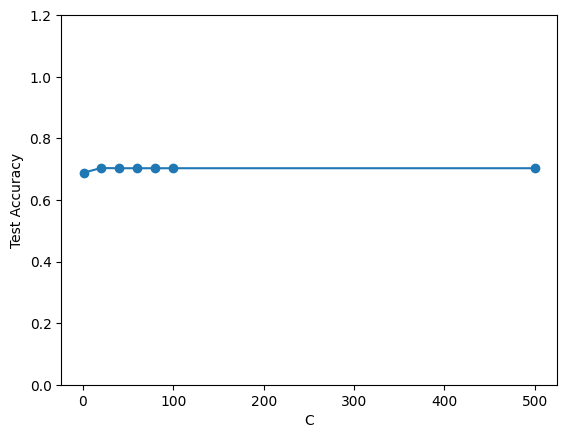

In [143]:
from matplotlib import pyplot as plt
plt.plot(c_list, test_acc, label="train", marker='o')
plt.xlabel("C")
plt.ylabel("Test Accuracy")
plt.ylim(0,1.2)